In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 25.7 MB/s 
     |████████████████████████████████| 182 kB 56.6 MB/s 
     |████████████████████████████████| 7.6 MB 60.7 MB/s 


In [ ]:
pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 19.3 MB/s 


In [ ]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 8.4 MB/s 
     |████████████████████████████████| 212 kB 60.6 MB/s 
     |████████████████████████████████| 115 kB 53.2 MB/s 
     |████████████████████████████████| 127 kB 58.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import shutil
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import datasets
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from collections import defaultdict
from transformers import XLNetTokenizerFast,XLNetTokenizer, XLNetForQuestionAnsweringSimple
from datasets import load_dataset
from keras_preprocessing.sequence import pad_sequences

# Load Data

In [ ]:
squad_v2 = False
datasets = load_dataset( "squad_v2"  if squad_v2 else  "squad" )

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

# Convert Data To DataFrame

In [ ]:
def convert_df(ori_data):
  data=[]
  for question_and_answers in ori_data:
    question=question_and_answers['question']
    context=question_and_answers['context']
    answr_text=question_and_answers['answers']['text'][0]
    answr_start=question_and_answers['answers']['answer_start'][0]
    answr_end=answr_start+len(answr_text)
    data.append({
        "question":question,
        "context":context,
        "answr_text":answr_text,
        "answr_start":answr_start,
        "answr_end":answr_end
    })
  return pd.DataFrame(data)

In [ ]:
df_train=convert_df(datasets[ "train" ]).iloc[0:2000,:]
df_valid=convert_df(datasets[ "validation" ]).iloc[0:500,:]

In [ ]:
df_valid,df_test=train_test_split(df_valid,test_size=0.5)

In [ ]:
df_valid=df_valid.reset_index(drop=True)

In [ ]:
df_test=df_test.reset_index(drop=True)

In [ ]:
print(df_train.shape,df_valid.shape,df_test.shape)

(2000, 5) (250, 5) (250, 5)


In [ ]:
tokenizer =XLNetTokenizerFast.from_pretrained("xlnet-base-cased")

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

# Check Data Max Length

In [ ]:
def Checklength(data):
  k=[]
  for i in range(len(data)):
    question=data.loc[i]['question']
    context	=data.loc[i]['context']
    k.append(len(tokenizer(question, context)["input_ids"]))
  return(max(k))

In [ ]:
#檢查最長數據大小
print(Checklength(df_train),Checklength(df_valid),Checklength(df_test))

494 449 444


# Adjust Position

In [ ]:
one=df_train.iloc[2,:]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Question : {}".format(one['question']))
print("Context : {}".format(one['context']))
print("Answer : {}".format(one['answr_text']))
print("Start : {}".format(one['answr_start']))
print("End : {}".format(one['answr_end']))

Question : The Basilica of the Sacred heart at Notre Dame is beside to which structure?
Context : Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Answer : the Main Building
Start : 279
End : 296


In [ ]:
inputs = tokenizer(one.question, one.context ,return_offsets_mapping=True,return_tensors="pt")

In [ ]:
inputs['input_ids']
torch.from_numpy(pad_sequences(inputs['input_ids'], maxlen=550, dtype="long", truncating="post", padding="post"))

In [ ]:
inputs['attention_mask']
torch.from_numpy(pad_sequences(inputs['attention_mask'], maxlen=550, dtype="long", truncating="post", padding="post",value=1))

In [ ]:
#原始答案起始與結束位置
start=one['answr_start']
end=one['answr_end']

#修正答案位置
sequence_ids=inputs['token_type_ids'].flatten()
idx = 0
while sequence_ids[idx] == 0 :
  idx += 1
  if sequence_ids[idx] ==1:
    break
  context_start = idx+1
try:
  while sequence_ids[idx] == 1:
        idx += 1
except:
  idx -= 1
#context_end = idx - 1
context_end = idx-2
print(context_start,context_end)

16 179


In [ ]:
start_positions = []
end_positions = []
start_char=start
end_char=end
offset=inputs["offset_mapping"][0]
if offset[context_start][0].item() > start_char or offset[context_end][1].item() < end_char:
  start_positions.append(0)
  end_positions.append(0)
else:
  # Otherwise it's the start and end token positions
  idx = context_start
  while idx <= context_end and offset[idx][0] <= start_char:
    idx += 1
  start_positions.append(idx - 1)

  idx = context_end
  while idx >= context_start and offset[idx][1] >= end_char:
    idx -= 1
  end_positions.append(idx+2)
start_rel = start_positions[0]
end_rel = end_positions[0]
print(start_rel,end_rel)
print(tokenizer.decode(inputs['input_ids'][0][start_rel:end_rel]))

83 86
the Main Building


# Define DataSet

In [ ]:
#1004original
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, input_max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.input_max_len = input_max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data_row=self.df.iloc[index]

        inputs = self.tokenizer(
          data_row['question'],
          data_row['context'],
          #回傳答案相對位置
          return_offsets_mapping=True,
          return_tensors="pt"
        )

        #原始答案起始與結束位置
        start=data_row['answr_start']
        end=data_row['answr_end']

        #修正答案位置
        sequence_ids=inputs['token_type_ids'].flatten()
        idx = 0
        while sequence_ids[idx] == 0 :
              idx += 1
              if sequence_ids[idx] ==1:
                break
        context_start = idx
        try:
          while sequence_ids[idx] == 1:
                idx += 1
        except:
            idx -= 1
        #context_end = idx - 1
        context_end = idx-2

        start_positions = []
        end_positions = []
        start_char=start
        end_char=end
        offset=inputs["offset_mapping"][0]
        if offset[context_start][0].item() > start_char or offset[context_end][1].item() < end_char:
          start_positions.append(0)
          end_positions.append(0)
        else:
          # Otherwise it's the start and end token positions
          idx = context_start
          while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
          start_positions.append(idx - 1)

          idx = context_end
          while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
          end_positions.append(idx + 2)
        start_rel = start_positions[0]
        end_rel = end_positions[0]
        return {
            'question':data_row['question'],
            'context':data_row['context'],
            'answer':data_row['answr_text'],
            'input_ids': torch.from_numpy(pad_sequences(inputs['input_ids'], maxlen=self.input_max_len, dtype="long", truncating="post", padding="post")).flatten(),
            'attention_mask': torch.from_numpy(pad_sequences(inputs['attention_mask'], maxlen=self.input_max_len, dtype="long", truncating="post", padding="post",value=1)).flatten(),
            # 'token_type_ids': inputs["token_type_ids"].flatten(),
            # 'offsets_mapping':inputs["offset_mapping"],
            'start':start,
            'end':end,
            'start_rel':torch.tensor([start_rel],dtype=torch.long),
            'end_rel':torch.tensor([end_rel],dtype=torch.long)
        }

# Test Data

In [ ]:
sample_train=CustomDataset(df_train, tokenizer,550)

In [ ]:
one=sample_train[20]
#one=data[1]
print(one['start_rel'])
print(one['end_rel'])
print(one['input_ids'])
# print(one['token_type_ids'])
# print(one['offsets_mapping'])
start=one['start_rel']
end=one['end_rel']
labeled_answer = tokenizer.decode(one["input_ids"][start : end ])
print(labeled_answer)
print(one['answer'])

In [ ]:
# import re
# b = []
# for m in re.finditer(r'\S+', one.question + one.context):
#   w = m.group(0)
#   t = (tokenizer.encode(w, add_special_tokens=False), (m.start(), m.end()-1))

#   b.append(t)
# for word_id in inputs_context.word_ids():
#     if word_id is not None:
#       try:
#         start , end =inputs_context.word_to_tokens(word_id)
#         print(tokenizer.decode(inputs_context['input_ids'][0][start:end]) )
#       except:
#         continue
# input_ids=torch.from_numpy(pad_sequences(inputs['input_ids'], maxlen=550, dtype="long", truncating="post", padding="post"))
# token_ids=torch.from_numpy(pad_sequences(inputs['token_type_ids'], maxlen=550, dtype="long", truncating="post", padding="post"))

# desired_output = []
# for word_id in inputs.word_ids():
#     if word_id is not None:
#       try:
#         start , end =inputs.word_to_tokens(word_id)
#         if start == end - 1:
#             tokens = [start, end]
#         else:
#             tokens = [start, end]
#         if len(desired_output) == 0 or desired_output[-1] != tokens:
#             desired_output.append(tokens)
#         #print(start,end)
#       except:
#        desired_output.append([0,0])
#     else:
#        desired_output.append([0,0])

# a=torch.tensor(desired_output,dtype=torch.long)
# offset_mapping = F.pad(a, pad=(0, 0, 0, 550 - a.shape[0]))

# tokenized_question = [tokenizer.tokenize(one['question'])]
# input_ids_question = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_question]
# input_ids_question[0].append(4)

# tokenized_contexts = [tokenizer.tokenize(one['context'])]
# input_ids_context = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_contexts]
# input_ids_context[0].append(4)
# input_ids_context[0].append(3)

# input_ids=[input_ids_question[0]+input_ids_context[0]]


# input_ids = pad_sequences(input_ids, maxlen=550, dtype="long", truncating="post", padding="post")
# torch.from_numpy(input_ids)

# Define Model

In [ ]:
model = XLNetForQuestionAnsweringSimple.from_pretrained("xlnet-base-cased")

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForQuestionAnsweringSimple: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForQuestionAnsweringSimple from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForQuestionAnsweringSimple from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForQuestionAnsweringSimple were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model.to(device)

XLNetForQuestionAnsweringSimple(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForwar

# Set Data and DataLoader

In [ ]:
input_max_len=512

In [ ]:
train_dataset = CustomDataset(df_train, tokenizer, input_max_len)
valid_dataset = CustomDataset(df_valid, tokenizer, input_max_len)
test_dataset = CustomDataset(df_test, tokenizer, input_max_len)

In [ ]:
print(len(train_dataset),len(valid_dataset),len(test_dataset))

2000 250 250


In [ ]:
TRAIN_BATCH_SIZE=4
VALID_BATCH_SIZE=4
TEST_BATCH_SIZE=4

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)
test_data_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [ ]:
for batch_idx, data in enumerate(train_data_loader):
  print(data['attention_mask'].shape)
  break

torch.Size([4, 512])


# Save The Best Model

In [ ]:
#加載模型參數
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into
    optimizer: optimizer we defined in previous training
    """
    # load check point
    # 如果使用cpu則後面需加上 map_location=torch.device('cpu')
    checkpoint = torch.load(checkpoint_fpath,map_location=torch.device('cpu'))
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss
    return model, optimizer, checkpoint['epoch'], valid_loss_min

#儲存模型參數
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

# Optimizer

In [ ]:
LEARNING_RATE=3e-5
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE, eps=1e-6, weight_decay=0.01)

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8000, gamma=0.75)

# Training Loop

In [ ]:
history=defaultdict(list)


def train(n_epochs, training_loader, validation_loader, model, optimizer, checkpoint_path, best_model_path):

  valid_loss_min = np.Inf

  for epoch in range(1,n_epochs+1):
    train_loss=0
    valid_loss=0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))

    for batch_idx, data in enumerate(training_loader):
      optimizer.zero_grad()

      input_ids=data['input_ids'].to(device)
      attention_mask =data['attention_mask'].to(device)
      start_positions=data['start_rel'].to(device)
      end_positions=data['end_rel'].to(device)
      outputs = model(input_ids,attention_mask,start_positions=start_positions,end_positions=end_positions)

      loss = outputs.loss

      #反向傳播
      loss.backward()

      #更新參數
      optimizer.step()

      #平均loss
      train_loss+=((1 / (batch_idx + 1)) * (loss.item() - train_loss))

    print('############# Epoch {}: Training End     #############'.format(epoch))

    print('############# Epoch {}: Validation Start   #############'.format(epoch))

    model.eval()

    #評估的時候不需要更新參數、計算梯度
    with torch.no_grad():

      #驗證集小批量迭代
      for batch_idx, data in enumerate(validation_loader, 0):

        #準備數據
        input_ids=data['input_ids'].to(device)
        attention_mask =data['attention_mask'].to(device)
        start_positions=data['start_rel'].to(device)
        end_positions=data['end_rel'].to(device)

        outputs = model(input_ids,attention_mask,start_positions=start_positions,end_positions=end_positions)

        loss = outputs.loss
        valid_loss+=((1 / (batch_idx + 1)) * (loss.item() - valid_loss))


      print('############# Epoch {}: Validation End     #############'.format(epoch))
      scheduler.step()
      # print(epoch, scheduler.get_last_lr()[0])

      train_loss=train_loss
      valid_loss=valid_loss

      history['epoch'].append(epoch)
      history['train_loss'].append(train_loss)
      history['valid_loss'].append(valid_loss)

      #打印此epoch結果
      print('Epoch: {} \t Training Loss: {:.6f}  \tValidation Loss: {:.6f} '.format(
            epoch,
            train_loss,
            valid_loss
            ))

      #儲存重要資訊
      checkpoint = {
            'epoch': epoch,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }

      #儲存
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)

      ## 如果驗證loss降低，則儲存模型
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss


    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

In [ ]:
#開始訓練模型
EPOCHS=2
#存放路徑
ckpt_path = "drive/MyDrive/xlnet_qa_1117/curr_ckpt"
best_model_path = "drive/MyDrive/xlnet_qa_1117/best_model.pt"
trained_model = train(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
1 3e-05
Epoch: 1 	 Training Loss: 2.600113  	Validation Loss: 1.548510 
Validation loss decreased (inf --> 1.548510).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
2 3e-05
Epoch: 2 	 Training Loss: 1.091156  	Validation Loss: 1.421846 
Validation loss decreased (1.548510 --> 1.421846).  Saving model ...
############# Epoch 2  Done   #############



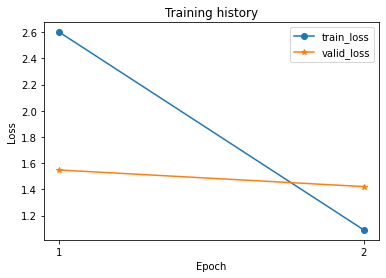

In [ ]:
#損失
plt.plot(history['epoch'],history['train_loss'], label='train_loss',marker="o")
plt.plot(history['epoch'],history['valid_loss'], label='valid_loss',marker="*")
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(history['epoch'])
plt.legend()

In [ ]:
def normalize_text(s):
  """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
  import string, re
  def remove_articles(text):
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    return re.sub(regex, " ", text)
  def white_space_fix(text):
    return " ".join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return "".join(ch for ch in text if ch not in exclude)
  # def lower(text):
  #   return text.lower()

  return white_space_fix(remove_articles(remove_punc(s)))

def exact_match(prediction, truth):
    return bool(normalize_text(prediction) == normalize_text(truth))


def compute_f1(prediction, truth):
  pred_tokens = normalize_text(prediction).split()
  truth_tokens = normalize_text(truth).split()

  # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
  if len(pred_tokens) == 0 or len(truth_tokens) == 0:
    return int(pred_tokens == truth_tokens)

  common_tokens = set(pred_tokens) & set(truth_tokens)

  # if there are no common tokens then f1 = 0
  if len(common_tokens) == 0:
    return 0

  prec = len(common_tokens) / len(pred_tokens)
  rec = len(common_tokens) / len(truth_tokens)

  return round(2 * (prec * rec) / (prec + rec), 2)

In [ ]:
def Test(model):
  F1_score=[]
  EM_score=[]
  model=model.eval()
  with torch.no_grad():
    for one in test_dataset:
      question=one['question']
      input_ids=one['input_ids'].to(device)
      attention_mask =one['attention_mask'].to(device)
      outputs = model(input_ids.reshape(1,512),attention_mask.reshape(1,512))
      answer_start_index = outputs.start_logits.argmax(dim=1)
      answer_end_index = outputs.end_logits.argmax(dim=1)

      #predict answer
      predict_answer = tokenizer.decode(one['input_ids'][answer_start_index.item() : answer_end_index.item()])

      #truth answer
      truth_answer = one['answer']

      F1_score.append(compute_f1(predict_answer,truth_answer))
      EM_score.append(exact_match(predict_answer,truth_answer))

  return sum(EM_score)/len(EM_score),np.mean(F1_score)

      # print("Question : {}".format(question))
      # print("True Answer : {}".format(truth_answer))
      # print("Pred Answer : {}".format(predict_answer))
      # print("Exact match : {}".format(exact_match(predict_answer,truth_answer)))
      # print("F1 score : {}\n".format(compute_f1(predict_answer,truth_answer)))


In [ ]:
scores=Test(model)
EM,F1=scores
print("Exact match : {}".format(EM))
print("F1 score : {}".format(round(F1,2)))

Exact match : 0.636
F1 score : 0.72


# Load Best Model

In [ ]:
#加載最優模型參數
load_ckp('drive/MyDrive/xlnet_qa_1117/best_model.pt', model, optimizer)

In [ ]:
def eval_model(model,testing_loader,n_examples):
  model=model.eval()
  acc=[]
  with torch.no_grad():
    #測試集小批量迭代
      for batch_idx, data in enumerate(testing_loader, 0):

        #準備數據
        input_ids=data['input_ids'].to(device)
        attention_mask =data['attention_mask'].to(device)


        start_positions=data['start_rel'].to(device)
        end_positions=data['end_rel'].to(device)

        outputs = model(input_ids,attention_mask)

        answer_start_index = torch.argmax(outputs['start_logits'], dim=1)
        answer_end_index = torch.argmax(outputs['end_logits'], dim=1)

        acc.append((((answer_start_index == start_positions.flatten())&(answer_end_index == end_positions.flatten())).sum()).item())

  return sum(acc)/n_examples

        #acc.append(((answer_start_index == start_positions.flatten())&(answer_end_index == end_positions.flatten())).sum()/len(start_positions).item())
        # acc.append(((answer_start_index == start_positions.flatten()).sum()/len(start_positions)).item())
        # acc.append(((answer_end_index == end_positions.flatten()).sum()/len(end_positions)).item())



In [ ]:
eval_model(
  model,
  test_data_loader,
  len(df_test)
)

In [ ]:
scores=Test(model)

In [ ]:
EM,F1=scores

In [ ]:
print("Exact match : {}".format(EM))
print("F1 score : {}".format(round(F1,2)))

Exact match : 0.56
F1 score : 0.66
